In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
import time

In [2]:
d = np.load("../data/training_data/splits.npz", allow_pickle=True)
X_train = d["X_train"]
X_test = d["X_test"]
y_train = d["y_train"]
y_test = d["y_test"]

In [3]:
f = np.load("../data/training_data/features_labels.npz", allow_pickle=True)
X = f["X"]
y = f["y"]

In [4]:
# Start with default parameters using sklearn API
xgb_basic = xgb.XGBClassifier(
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
)

# Train the model
start_time = time.time()
xgb_basic.fit(X_train, y_train)
training_time = time.time() - start_time

# Make predictions
y_pred_basic = xgb_basic.predict(X_test)

# Evaluate
accuracy_basic = accuracy_score(y_test, y_pred_basic)
print("Basic XGBoost Results:")
print(f"Accuracy: {accuracy_basic:.4f}")
print(f"Training time: {training_time:.2f} seconds")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_basic))

Basic XGBoost Results:
Accuracy: 0.9631
Training time: 0.39 seconds

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       425
           1       0.99      0.94      0.96       379
           2       0.92      0.96      0.94       397
           3       0.94      0.95      0.95       399

    accuracy                           0.96      1600
   macro avg       0.96      0.96      0.96      1600
weighted avg       0.96      0.96      0.96      1600



Top 10 Most Important Features:
       feature  importance
15  Feature_15    0.226721
10  Feature_10    0.097956
7    Feature_7    0.086497
11  Feature_11    0.083174
3    Feature_3    0.050922
9    Feature_9    0.049356
6    Feature_6    0.048863
14  Feature_14    0.046122
5    Feature_5    0.044522
2    Feature_2    0.044080


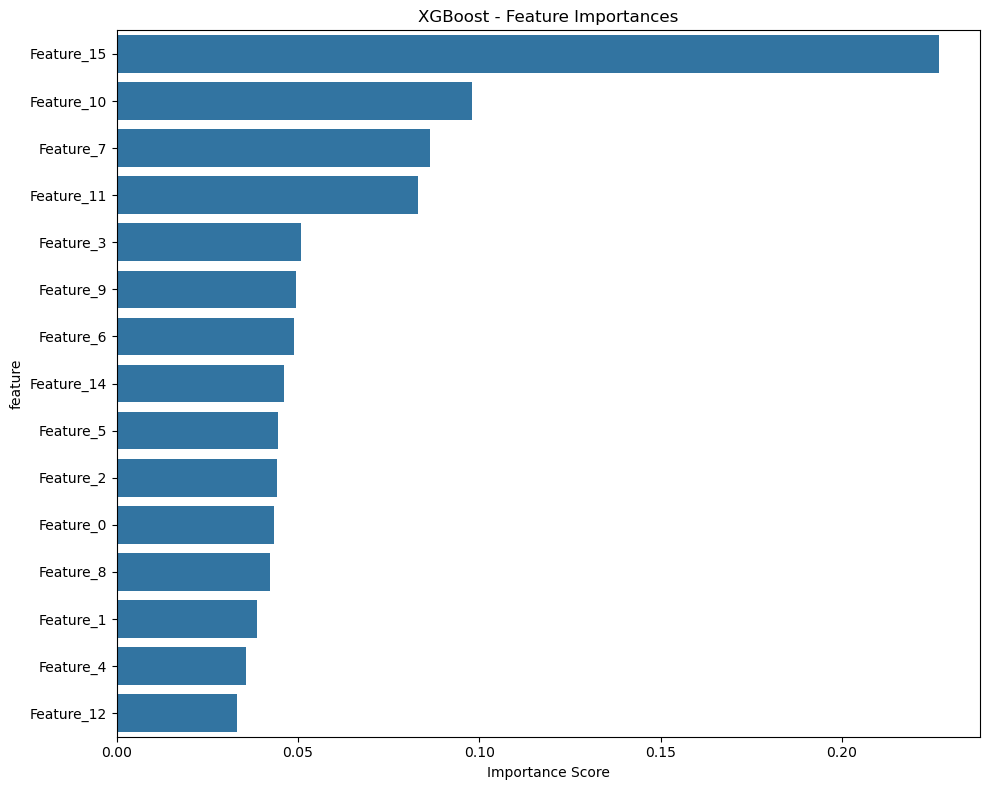

<Figure size 1000x800 with 0 Axes>

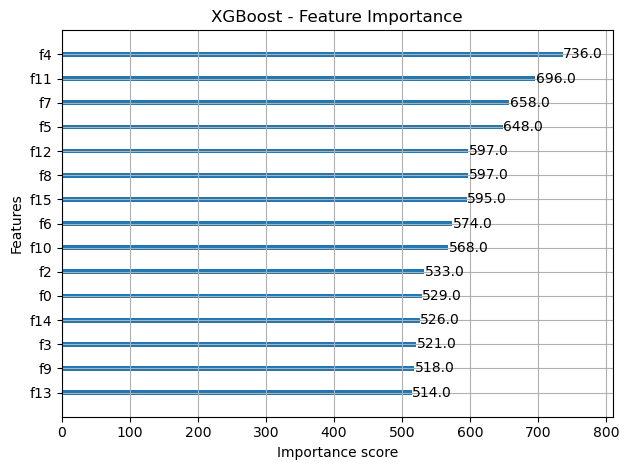

In [5]:
# Get feature importances
feature_importances = xgb_basic.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'feature': X.columns if hasattr(X, 'columns') else [f'Feature_{i}' for i in range(X.shape[1])],
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df.head(15), x='importance', y='feature')
plt.title('XGBoost - Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Plot built-in feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_basic, max_num_features=15)
plt.title('XGBoost - Feature Importance')
plt.tight_layout()
plt.show()

In [6]:
# Define parameter distribution for RandomizedSearch
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [1, 1.5, 2.0, 3.0]
}

print("Starting Randomized Search for XGBoost...")
start_time = time.time()

# Perform randomized search
random_search = RandomizedSearchCV(
    xgb.XGBClassifier(
        random_state=42, 
        n_jobs=-1, 
        eval_metric='logloss',
    ),
    param_distributions=param_dist,
    n_iter=30,  # Reduced for faster execution
    cv=3,       # Reduced for faster execution
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

print(f"Randomized search completed in {time.time() - start_time:.2f} seconds")

# Best parameters and score
print("\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

Starting Randomized Search for XGBoost...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Randomized search completed in 7.07 seconds

Best parameters found:
  subsample: 0.8
  reg_lambda: 1.5
  reg_alpha: 0.5
  n_estimators: 500
  max_depth: 6
  learning_rate: 0.2
  gamma: 0
  colsample_bytree: 1.0
Best cross-validation score: 0.9600


In [7]:
# Define a balanced parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

grid_search = GridSearchCV(
    xgb.XGBClassifier(
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss',
    ),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

def gridsearch(grid_search, X_train, X_test, y_train, y_test):
    print("Grid Search...")
    
    grid_search.fit(X_train, y_train)
    
    print("Grid Search Completed!")
    print("Best parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    # Final evaluation
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    return best_model, grid_search.best_params_, test_accuracy

# Run simple grid search
final_model, best_params, final_accuracy = gridsearch(grid_search,
    X_train, X_test, y_train, y_test
)

Grid Search...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Grid Search Completed!
Best parameters:
  colsample_bytree: 0.9
  learning_rate: 0.15
  max_depth: 6
  n_estimators: 300
  subsample: 0.8
Best CV score: 0.9689
Test Accuracy: 0.9750


In [8]:
# Use the best model from tuning
final_xgb = grid_search.best_estimator_

# Make final predictions
y_pred_final = final_xgb.predict(X_test)
y_pred_proba = final_xgb.predict_proba(X_test)  # Probability scores

# Comprehensive evaluation
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"\nFinal XGBoost Model Performance:")
print(f"Test Accuracy: {final_accuracy:.4f}")
print(f"Best Parameters: {random_search.best_params_}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_final))


Final XGBoost Model Performance:
Test Accuracy: 0.9750
Best Parameters: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.5, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       425
           1       0.99      0.96      0.97       379
           2       0.95      0.97      0.96       397
           3       0.96      0.97      0.97       399

    accuracy                           0.97      1600
   macro avg       0.98      0.97      0.97      1600
weighted avg       0.98      0.97      0.98      1600



In [9]:
# Simple cross-validation
cv_scores = cross_val_score(final_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

print("Cross-Validation Results:")
print(f"Fold scores: {[f'{s:.4f}' for s in cv_scores]}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Test set performance
test_accuracy = accuracy_score(y_test, final_model.predict(X_test))
print(f"Test Set Accuracy: {test_accuracy:.4f}")

# Performance comparison
print(f"\nPerformance Summary:")
print(f"Best CV Score from Grid Search: {grid_search.best_score_:.4f}")
print(f"5-fold CV Mean: {cv_scores.mean():.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Cross-Validation Results:
Fold scores: ['0.9664', '0.9688', '0.9719', '0.9734', '0.9641']
Mean CV Accuracy: 0.9689 (+/- 0.0069)
Test Set Accuracy: 0.9750

Performance Summary:
Best CV Score from Grid Search: 0.9689
5-fold CV Mean: 0.9689
Final Test Accuracy: 0.9750


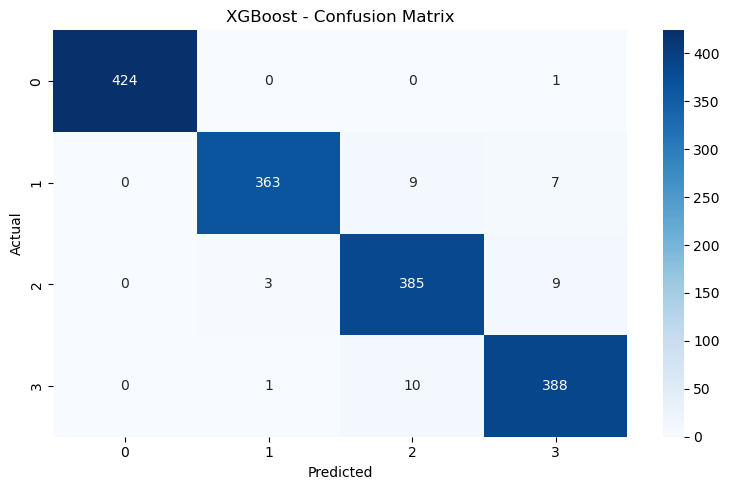

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(15, 5))

# Subplot 1: Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), 
            yticklabels=np.unique(y_test))
plt.title('XGBoost - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Subplot 2: ROC Curve (for binary classification)
if len(np.unique(y_test)) == 2:
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

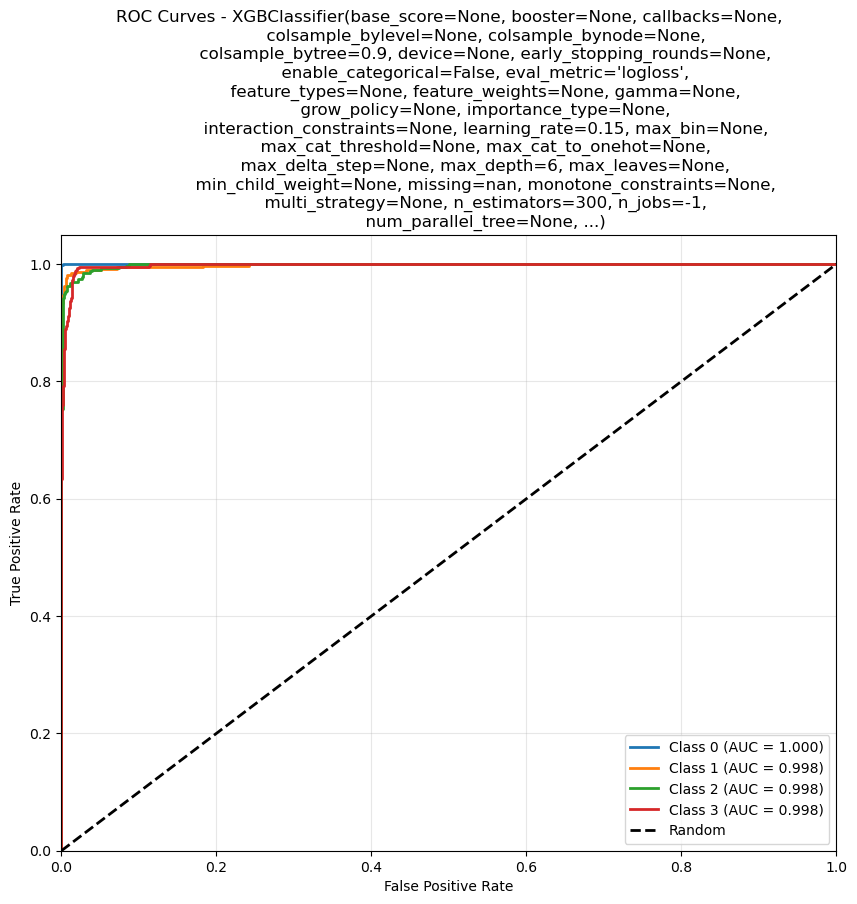

In [11]:
# Get predictions for all classes
y_pred_proba = final_xgb.predict_proba(X_test)

# Binarize the labels (convert to one-hot encoding)
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Calculate ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.3f})')

# Add random classifier line and format
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves - {final_xgb}')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
# Save the classification report
report_dict = classification_report(y_test, y_pred_final, output_dict=True)
df = pd.DataFrame(report_dict).transpose()
df.to_csv("performance_metrics/classification_reports/xgb_report.csv") 

In [13]:
import joblib
# Save the trained model
joblib.dump(final_xgb, 'trained_models/xgb_model.pkl')
print("XGBoost model saved")

XGBoost model saved
